# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

**Шаги для выбора локации:**
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## 1. Загрузка и подготовка данных

In [1]:
# Установка profiling
#!pip install pandas-profiling==2.8.0

In [2]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
from numpy.random import RandomState

#import pandas_profiling
#from pandas_profiling import ProfileReport

import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pd.options.mode.chained_assignment = None
from scipy import stats as st

import seaborn as sns

import matplotlib.pyplot as plt

import time
import timeit
from datetime import datetime
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Используемые константы
RS = 1234 #random state 

REGON_WELLS = 500 #количество рассматриваемых скважин для разработки (500 скважин)
BEST_WELLS = 200 #количество лучших скважин для разработки (200 скважин)
BUDGET = 10**10 #бюджет на разработку скважин в регионе 10 млрд руб
PROFIT_WELL = 45*10**4 #доход на 1000 баррелей

In [4]:
# Загружаем данные
pth1 = '/datasets/geo_data_0.csv'
pth2 = 'geo_data_0.csv'

if os.path.exists(pth1):
    data_1 = pd.read_csv(pth1)
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')
    
elif os.path.exists(pth2):
    data_1 = pd.read_csv(pth2)
    data_2 = pd.read_csv('geo_data_1.csv')
    data_3 = pd.read_csv('geo_data_2.csv')
#    print('Путь 2')
else:
    print('Ошибка загрузки данных, проверьте правильность пути, наличие файла')

In [5]:
# Загружаем данные версия2
#try:
#    data_1 = pd.read_csv('geo_data_0.csv')
#    data_2 = pd.read_csv('geo_data_1.csv')
#    data_3 = pd.read_csv('geo_data_2.csv')
#except:
#    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
#    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
#    data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
# Создадим копии данных, с которыми будем работать
df_1 = data_1.copy()
df_2 = data_2.copy()
df_3 = data_3.copy()

In [7]:
# Отчет по данным
#df_1.profile_report()
#df_2.profile_report()
#df_3.profile_report()

In [8]:
# Создаем словарь исходных 3х таблиц
dct_df = {'df_1': df_1, 'df_2': df_2, 'df_3': df_3}

In [9]:
# Выводим первые и последние 5 строк каждой таблицы данных
list(map(lambda x: [print(), display(x, dct_df[x].head(),dct_df[x].tail())], dct_df))

'df_1'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


'df_2'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


'df_3'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


[[None, None], [None, None], [None, None]]

In [10]:
# Смотрим общую информацию о данных
list(map(lambda x: [display(x, dct_df[x].info()), print('\n')], dct_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'df_1'

None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'df_2'

None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'df_3'

None

[[None, None], [None, None], [None, None]]

In [11]:
# Проверка на явные дубликаты
list(map(lambda x: print(f' Явных дубликатов в таблице {x}: {dct_df[x].duplicated().sum()}'), dct_df))

 Явных дубликатов в таблице df_1: 0
 Явных дубликатов в таблице df_2: 0
 Явных дубликатов в таблице df_3: 0


[None, None, None]

In [12]:
# Проверка на неявные дубликаты
list(map(lambda x: print(f' Неявных дубликатов в таблице {x}: {dct_df[x]["id"].duplicated().sum()}'), dct_df))

 Неявных дубликатов в таблице df_1: 10
 Неявных дубликатов в таблице df_2: 4
 Неявных дубликатов в таблице df_3: 4


[None, None, None]

In [13]:
# Список неявных дубликатов по id
id_double = pd.DataFrame() # создаем пустую таблицу для переченя повторяющихся id
for x in dct_df:
    id_double = pd.DataFrame(pd.concat([id_double, dct_df[x]["id"][dct_df[x]["id"].duplicated()]]))
#list(map(lambda x: id_double.append(dct_df[x]["id"][dct_df[x]["id"].duplicated()]), dct_df))

id_double.T #транспонированный столбец с id дубликатов

,7530,41724,51970,63593,66136,69163,75715,90815,92341,97785,41906,82178,82873,84461,43233,49564,55967,95090
0,HZww2,bxg6G,A5aEY,QcMuo,74z30,AGS9W,Tdehs,fiKDv,TtcGQ,bsk9y,LHZR0,bfPNe,wt4Uk,5ltQ6,xCHr8,VF7Jo,KUPhW,Vcm5J


In [14]:
# Выводим повторы в id скважин во всех таблицах
for j in dct_df:
    for i, k in id_double.iterrows():
        #print(k[0])
        val = dct_df[j]['id']
        if k[0] in val.values:
            display(j, dct_df[j][val == k[0]])           

'df_1'

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


'df_1'

,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


'df_1'

,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


'df_1'

,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


'df_1'

,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


'df_1'

,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


'df_1'

,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


'df_1'

,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


'df_1'

,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


'df_1'

,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


'df_2'

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


'df_2'

,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


'df_2'

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


'df_2'

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


'df_3'

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


'df_3'

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


'df_3'

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


'df_3'

,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [15]:
# Посмотрим на статистики таблиц
list(map(lambda x: [print(f'Статистики таблицы {x}:'), display(dct_df[x].describe())], dct_df))

Статистики таблицы df_1:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Статистики таблицы df_2:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Статистики таблицы df_3:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


[[None, None], [None, None], [None, None]]

Корреляционная матрица таблицы df_1


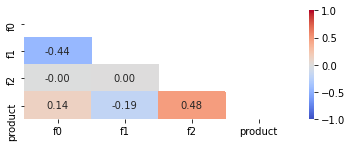

Корреляционная матрица таблицы df_2


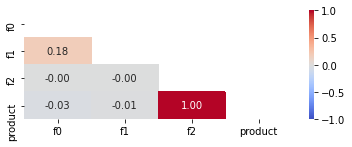

Корреляционная матрица таблицы df_3


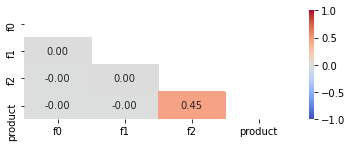

In [16]:
# Посмотрим корреляцонную матрицу признаков для каждой таблицы

for j in dct_df:
    matrix = np.triu(dct_df[j].corr())
    fig, ax = plt.subplots(figsize=(6, 2))
    sns.heatmap(dct_df[j].corr(), annot=True, fmt='.2f', mask=matrix,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
    print(f'Корреляционная матрица таблицы {j}')
    plt.show()
    

In [17]:
# Функция для построения диаграммы размаха
def box_plt(idx_features):
    for j in dct_df:
        plt.figure(figsize=(7,2))
        dct_df[j][idx_features].plot(kind='box',vert=False)
        plt.grid()
        plt.title(f'Диаграмма размаха таблицы {j}, признака {idx_features}',fontsize=10)
        plt.show()

In [18]:
# Список количественных признаков
quant_feachers = ['f0', 'f1', 'f2', 'product']

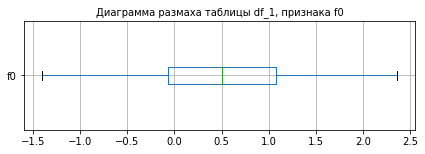

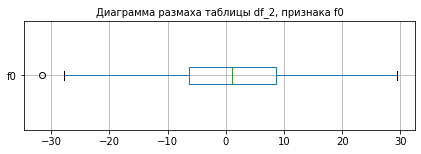

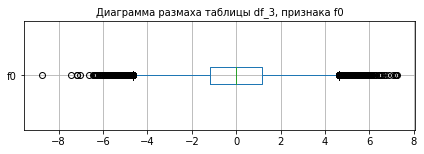

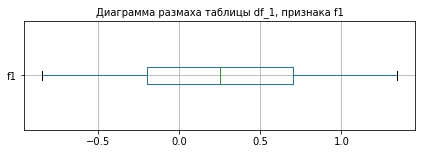

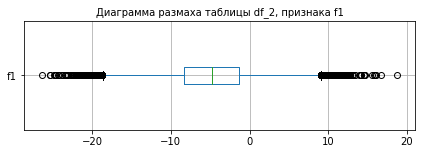

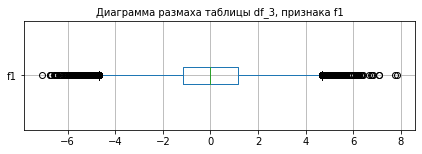

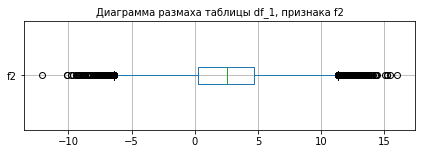

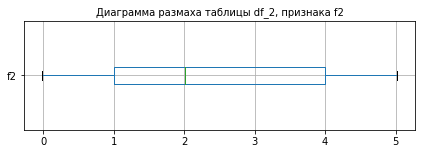

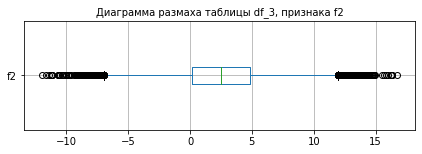

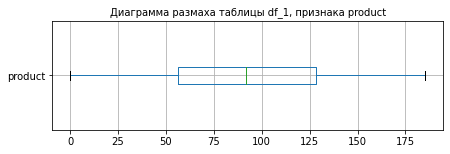

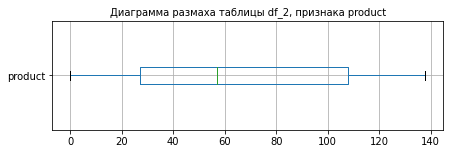

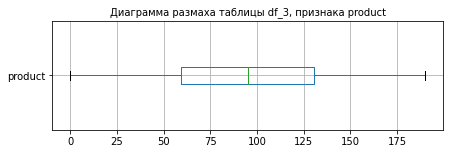

[None, None, None, None]

In [19]:
# Построениe диаграммы размаха для количественных признаков всех таблиц 
list(map(lambda x: box_plt(x), quant_feachers))

In [20]:
# Распределение количественных признаков в каждом из регионов (Гистограмма)
def hist_plt(idx_features):
    for j in dct_df:
        plt.figure(figsize=(7,2))
        sns.histplot(dct_df[j][idx_features], color='red', fill= True , alpha= .3 , linewidth= 0)
        plt.grid()
        plt.title(f'Распределение признака {idx_features} таблицы {j}',fontsize=10)
        plt.show()

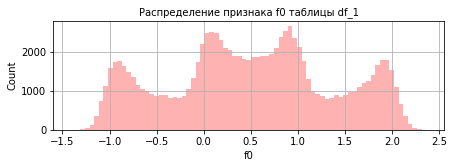

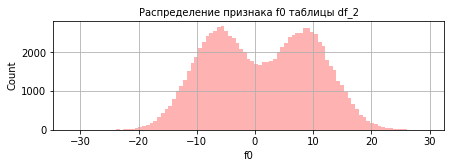

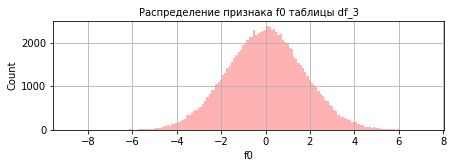

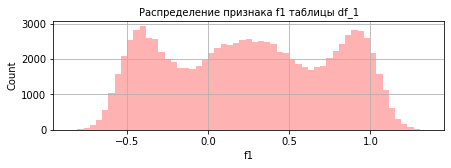

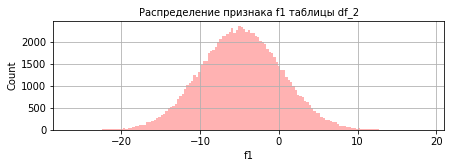

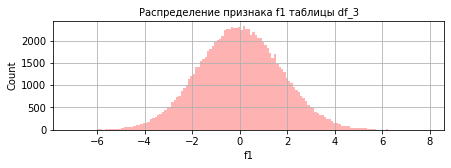

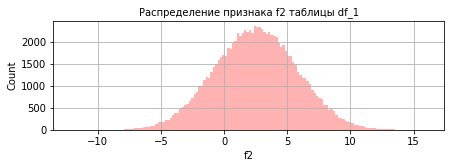

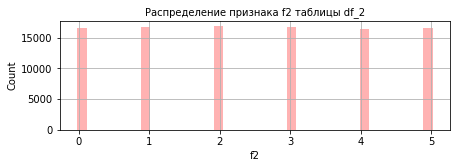

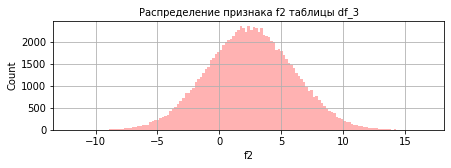

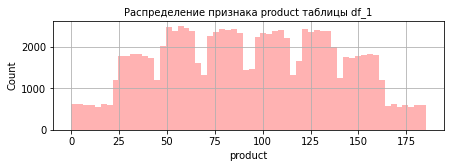

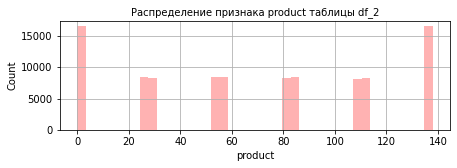

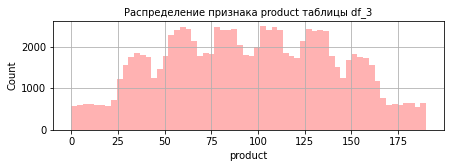

[None, None, None, None]

In [21]:
# Построениe диаграммы распределения признаков 
list(map(lambda x: hist_plt(x), quant_feachers))

## Вывод 1
Все три таблицы содержат по 100 000 строк и по 5 признаков их описывающих.  
Названия колонок корректные.  
Индексы без пропусков.  
Все признаки, кроме id, количественные.  
Типы данных верные.  
Пропусков и явных дубликатов нет.  

Найдены неявные дубликаты во всех 3х таблицах в количестве 10, 4 и 4 шт соответственно, стоит обратить на это внимание закзчика и уточнить, является ли id скважин в присланных данных полным, какие есть особенности в этих данных. Возможно, такие дубликаты появились из-за некорректного заполнения, обновления, загрузки, выгрузки базы данных заказчика. Так как на момент исследования невозможно выявить природу таких дубликатов и их немного (18 скважин, у каждой по 1 повтору), то оставим данные без изменения.  
Во 2м регионе сильная корреляция (=1) между целевым признаком `product` и признаком `f2`.  
Сильной корреляционной связи между признаками в каждой из таблиц нет.  
Рспределение целевого признака `product` не является нормальным во всех трех регионах.  
Более схожие распределения целевого признака имеют регионы 1 и 3. 
БОльшая часть остальные признаков имеет ненормальное распределение.

## 2. Обучение и проверка модели

In [22]:
# Формируем из каждой таблицы две: c целевым признаком и с остальными признаками
features = ['f0', 'f1', 'f2']
target = ['product']

# таблицы с признаками без целевого
features_1 = df_1[features]
features_2 = df_2[features]
features_3 = df_3[features]

# таблицы с целевым признаком
target_1 = df_1[target]
target_2 = df_2[target]
target_3 = df_3[target]

In [23]:
# Функция обучения модели LinearRegression для предсказания объёма запасов
# в новых скважинах для каждого региона 
# На входе таблица признаков и целевого признака, номер региона в кавычках (num_region)
# Делит данные на обучающую и валидационную выборки, масштабирует количественные признаки
# Выводит предсказанный средний запас сырья (в тыс. баррелей) и RMSE модели
# На выходе: предсказания объема сырья в скважинах на валидационной выборке и правильные ответы,  RMSE модели
    
def model_lr(features, target, num_region):
    
    # деление исходных данных на обучающую и валидационную выборки
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RS
    )
    # масштабирование количественных признаков
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    quant_feachers = list(features.columns)
    features_train = pd.DataFrame(features_train, columns = quant_feachers)
    features_valid = pd.DataFrame(features_valid, columns = quant_feachers)
    display('Отмасштабированные признаки обучающей выборки: \n', features_train.head(), \
            'Отмасштабированные признаки валидационной выборки:', features_valid.head()) # вывод нескольких строк выборки для проверки масштабирования признаков
    
    # создание модели LinearRegression
    model = LinearRegression() 
    model.fit(features_train, target_train) # обучение модели  
    predict = model.predict(features_valid) # предсказания на валидационной выборке
    predict_mean = predict.mean() # средний запас предсказанного сырья
    rmse = round(mean_squared_error(target_valid, predict)**.5, 0) # RMSE модели
    
    predict = pd.Series(*predict.reshape(1,-1)) # преобразовываем в столбец с формированием индексов
    target_valid = pd.Series(target_valid['product']).reset_index(drop=True) # cброс индексов
        
    print(f' Предсказанный средний запас сырья в скважине Региона {num_region}: {predict_mean:.3f}  (тыс. баррелей)')
    print(f' RMSE модели: {rmse:.0f}')
    print(f' Доли обучающей и валидационной выборок {100*features_train.shape[0]/features.shape[0]}% : {100*features_valid.shape[0]/features.shape[0]}%')
    return predict_mean, predict, target_valid, rmse

In [24]:
# Предсказания объёма запасов в регионе 1
predict_mean_1, predict_1, target_valid_1, rmse_1 = model_lr(features_1, target_1, '1')

'Отмасштабированные признаки обучающей выборки: \n'

,f0,f1,f2
0,0.683931,0.174512,0.312363
1,0.167534,0.730721,0.529259
2,0.132988,0.730769,0.480080
3,0.182512,0.690132,0.616851
4,0.622053,0.479810,0.546311


'Отмасштабированные признаки валидационной выборки:'

,f0,f1,f2
0,0.691003,0.518095,0.455878
1,0.457315,0.784988,0.298212
2,0.556800,0.193820,0.706048
3,0.634053,0.555720,0.590536
4,0.505223,0.721752,0.595449


 Предсказанный средний запас сырья в скважине Региона 1: 92.430  (тыс. баррелей)
 RMSE модели: 38
 Доли обучающей и валидационной выборок 75.0% : 25.0%


In [25]:
# Предсказания объёма запасов в регионе 2
predict_mean_2, predict_2, target_valid_2, rmse_2 = model_lr(features_2, target_2, '2')

'Отмасштабированные признаки обучающей выборки: \n'

,f0,f1,f2
0,0.703003,0.517157,0.399483
1,0.633913,0.339827,0.200828
2,0.685379,0.413118,0.799873
3,0.726856,0.439844,0.400593
4,0.422741,0.549099,0.597590


'Отмасштабированные признаки валидационной выборки:'

,f0,f1,f2
0,0.758833,0.660854,0.399920
1,0.504467,0.356199,0.797650
2,0.769477,0.450145,0.005022
3,0.489100,0.217015,0.997010
4,0.582175,0.351660,0.202015


 Предсказанный средний запас сырья в скважине Региона 2: 68.802  (тыс. баррелей)
 RMSE модели: 1
 Доли обучающей и валидационной выборок 75.0% : 25.0%


In [26]:
# Предсказания объёма запасов в регионе 3
predict_mean_3, predict_3, target_valid_3, rmse_3 = model_lr(features_3, target_3, '3')

'Отмасштабированные признаки обучающей выборки: \n'

,f0,f1,f2
0,0.435446,0.517255,0.295157
1,0.559007,0.512550,0.742032
2,0.601203,0.481587,0.771141
3,0.410739,0.476090,0.406316
4,0.519368,0.590304,0.521231


'Отмасштабированные признаки валидационной выборки:'

,f0,f1,f2
0,0.608804,0.275798,0.370273
1,0.473410,0.466373,0.335401
2,0.698536,0.347586,0.422568
3,0.510393,0.428728,0.526897
4,0.447445,0.511369,0.626371


 Предсказанный средний запас сырья в скважине Региона 3: 94.916  (тыс. баррелей)
 RMSE модели: 40
 Доли обучающей и валидационной выборок 75.0% : 25.0%


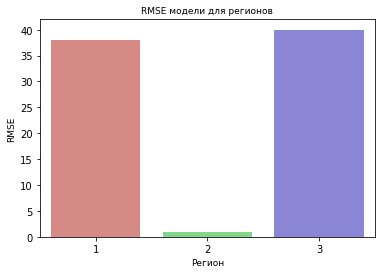

In [27]:
# График rmse для регионов
rmse =pd.DataFrame([{'1':rmse_1, '2':rmse_2, '3':rmse_3}])
sns.barplot(data=rmse, palette='hls', alpha=0.8)
plt.title(f'RMSE модели для регионов', fontsize=9)
plt.xlabel('Регион', fontsize=9)
plt.ylabel('RMSE', fontsize=9)
plt.show()
warnings.filterwarnings("ignore")

## Вывод 2

Для каждого региона обучили модель линейной регрессии и получили предсказания среднего запаса сырья в скважине региона.  

Регион 1:  
 Предсказанный средний запас сырья в скважине Региона 1: 92.430  (тыс. баррелей)  
 RMSE модели: 38
 
Регион 2:  
 Предсказанный средний запас сырья в скважине Региона 2: 68.802  (тыс. баррелей)  
 RMSE модели: 1  

Регион 3:  
 Предсказанный средний запас сырья в скважине Региона 3: 94.916  (тыс. баррелей)  
 RMSE модели: 40  

Cредний запас предсказанного сырья в скважине региона 2 меньше, чем в 1 и в 3, но качество предсказания значительно выше других регионов - rmse в 40 раз меньше.

## 3. Подготовка к расчёту прибыли

In [28]:
# Расчет объёма сырья для безубыточной разработки новой скважины
breakeven_point = BUDGET / (BEST_WELLS * PROFIT_WELL)
print(f'Точка безубыточности для скважины: {breakeven_point:.2f} (тыс. баррелей)')

Точка безубыточности для скважины: 111.11 (тыс. баррелей)


 Разница с безубыточным объемом в регионе 1:  -18.61
 Разница с безубыточным объемом в регионе 2:  -42.29
 Разница с безубыточным объемом в регионе 3:  -16.11


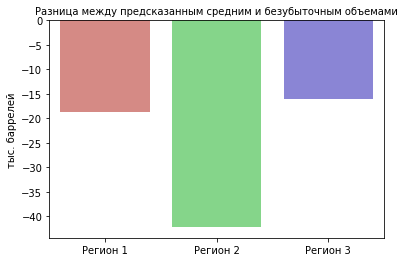

In [29]:
# Сравнение среднего объема запасов скважины с объемом точки безубыточности (для каждого региона) 
a=[] # список для заолнения разницами

target_mean_1 = target_1.mean()[0]
target_mean_2 = target_2.mean()[0]
target_mean_3 = target_3.mean()[0]

mean_list = pd.Series([target_mean_1, target_mean_2, target_mean_3]) # список предсказанных средних объемов в регионах

list(map(lambda x: [print(f' Разница с безубыточным объемом в регионе {1+pd.Index(mean_list).get_loc(x)}: \
 {round(x - breakeven_point, 2)}'), \
                   a.append(x - breakeven_point)], mean_list)) #заполнение списака а разницами
# График разниц
a = pd.DataFrame([{'Регион 1': a[0], 'Регион 2': a[1], 'Регион 3': a[2]}])
sns.barplot(data=a, palette='hls', alpha=0.8)
plt.title('Разница между предсказанным средним и безубыточным объемами', fontsize=10)
plt.ylabel('тыс. баррелей', fontsize=10)
plt.show()    


## Вывод 3   

Рассчитали, что достаточный объём сырья для безубыточной разработки новой скважины равен 111,11 тыс. баррелей.  

Сравнили безубыточный объём сырья со средним запасом по региону: ни в одном из регионов недостаточно объема для безубыточной работы при данном бюджете.

## 4. Расчёт прибыли и рисков 

In [30]:
# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
# на входе ответы и предсказания на валидационной выборке, rs - заданный random_state, номер региона в кавычках
# выводит сумму целевого значения объёма сырья, соответствующее предсказаниям лучших 200 скважин
# на выходе - прибыль для полученного объёма сырья

def profits(target, predict, rs, num_region):
 
    k=0 # счетчик для проверки совпадения инексов
    predict_sample = predict.sample(n=REGON_WELLS, replace = True, random_state=rs)   # случайная выборка из 500 скважин                    
    predict_best = predict_sample.sort_values(ascending=False).iloc[:BEST_WELLS] # 200 скважин с максимальными значениями предсказаний                        
    target_best = target[predict_best.index] # целевое значение объёма сырья, соответствующее этим предсказаниям
    
    # проверка на совпадение инексов
    for i in predict_best.index: 
        if i not in target_best.index:
            k += 1
            print(k)
            
    volume_best = target_best.sum() # сумма целевого значения объёма сырья, соответствующее предсказаниям лучших 200 скважин
    profit = (volume_best * PROFIT_WELL - BUDGET)/10**6 # прибыль для полученного объёма сырья млн.руб
    
    return profit, volume_best, num_region    

<div class="alert alert-block alert-info">
 Добавила `replace = True`.  Спасибо за пояснение!

In [31]:
# Вычисление прибыли по выбранным скважинам и предсказаниям модели для каждого региона
profit_1 = profits(target_valid_1, predict_1, RS, '1')
profit_2 = profits(target_valid_2, predict_2, RS, '2')
profit_3 = profits(target_valid_3, predict_3, RS, '3')

Регион 1: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23629.64 тыс.баррелей
 Прибыль для полученного объёма сырья: 633.34 млн. руб. 

Регион 2: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 22985.74 тыс.баррелей
 Прибыль для полученного объёма сырья: 343.58 млн. руб. 

Регион 3: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23288.99 тыс.баррелей
 Прибыль для полученного объёма сырья: 480.05 млн. руб. 



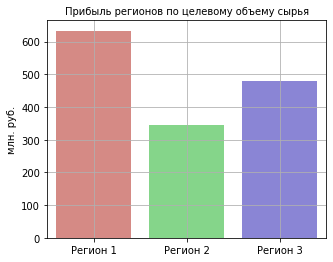

In [32]:
# Вывод прибыли по регионам с графиком
profit_list = [profit_1, profit_2, profit_3]
a = []
list(map(lambda x: [print(f'Регион {x[2]}: \n Cумма целевого значения объёма сырья по лучшим скважинам: {x[1]:.2f} тыс.баррелей'), \
        print(f' Прибыль для полученного объёма сырья: {x[0]:.2f} млн. руб. \n'), a.append(x[0])] , profit_list))

# График прибыли
a = pd.DataFrame([{'Регион 1': a[0], 'Регион 2': a[1], 'Регион 3': a[2]}])
plt.figure(figsize=(5,4))
sns.barplot(data=a, palette='hls', alpha=0.8)
plt.title('Прибыль регионов по целевому объему сырья', fontsize=10)
plt.ylabel('млн. руб.', fontsize=10)
plt.grid()
plt.show()    


## Вывод 4 .1 
При расчете прибыли регионов по целевому объему сырья получили следующие результаты.

Регион 1: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23629.64 тыс.баррелей
 Прибыль для полученного объёма сырья: 633.34 млн. руб. 

Регион 2: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 22985.74 тыс.баррелей
 Прибыль для полученного объёма сырья: 343.58 млн. руб. 

Регион 3: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23288.99 тыс.баррелей
 Прибыль для полученного объёма сырья: 480.05 млн. руб. 
 
На первом месте по уровню прибыли - Регион 1.  
На втором - Регион 3.  
Самая маленькая прибыль в Регионе 2.

In [33]:
# Функция расчета риска и прибыли для каждого региона
# на входе ответы и предсказания на валидационной выборке, номер региона в кавычках
# на выходе - прибыль, полученная при помощи техники bootstrap, средняя прибыль,
# 95%-й доверительный интервал и риск убытков
def boot_profit (target, predict, num_region):
    
    rs = np.random.RandomState(RS)
    alpha = 0.025
    profit = []
    for _ in range(1000):
        b_profit = profits(target, predict, rs, num_region) #применение техники bootstrap с 1000 выборками, 
        profit.append(b_profit[0])                          #чтобы найти распределение прибыли
    profit = pd.Series(profit)
    profit_mean = profit.mean() # среднее значение прибыли
    risk = 100*(profit < 0).mean() # расчет риска в %
    lower = profit.quantile(alpha) # доверительный интервал для среднего значения прибыли
    upper = profit.quantile(1-alpha)
          
    return profit, profit_mean, lower, upper, risk, num_region 

In [34]:
# Вычисление прибыли и риска при bootstrap для каждого региона
bprofit_1 = boot_profit(target_valid_1, predict_1, '1')
bprofit_2 = boot_profit(target_valid_2, predict_2, '2')
bprofit_3 = boot_profit(target_valid_3, predict_3, '3')

In [35]:
# Вывод прибыли по регионам с графиком
bprofit_list = [bprofit_1, bprofit_2, bprofit_3]
b = []
c = []
d = []
list(map(lambda x: [print(f'Регион {x[5]}: \n Средняя прибыль {x[1]:.2f} млн. руб.'), \
        print(f' 95%-доверительный интервал: [{x[2]:.2f}, {x[3]:.2f}] млн. руб.'), \
                    print(f' Риск убытков: {x[4]:.2f} % \n'), b.append(x[1]), c.append(x[0]), d.append(x[4])], bprofit_list))

Регион 1: 
 Средняя прибыль 379.40 млн. руб.
 95%-доверительный интервал: [-107.98, 918.80] млн. руб.
 Риск убытков: 7.20 % 

Регион 2: 
 Средняя прибыль 429.09 млн. руб.
 95%-доверительный интервал: [32.45, 847.36] млн. руб.
 Риск убытков: 1.90 % 

Регион 3: 
 Средняя прибыль 353.93 млн. руб.
 95%-доверительный интервал: [-210.85, 892.07] млн. руб.
 Риск убытков: 9.00 % 



[[None, None, None, None, None, None],
 [None, None, None, None, None, None],
 [None, None, None, None, None, None]]

   Регион 1  Регион 2  Регион 3
0     379.4    429.09    353.93


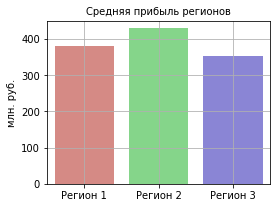

   Регион 1  Регион 2  Регион 3
0       7.2       1.9       9.0


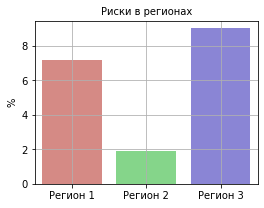

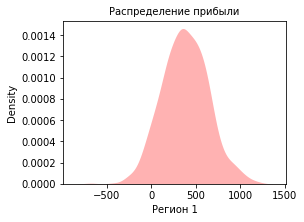

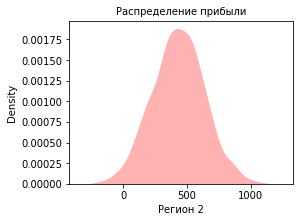

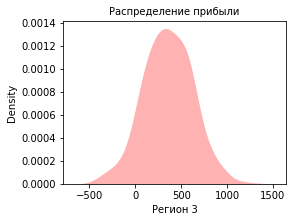

In [36]:
# График средней прибыли
b = pd.DataFrame([{'Регион 1': b[0], 'Регион 2': b[1], 'Регион 3': b[2]}])
print(round(b,2))

plt.figure(figsize=(4,3))
plt.title('Средняя прибыль регионов', fontsize=10)
plt.ylabel('млн. руб.', fontsize=10)
sns.barplot(data=b, palette='hls', alpha=0.8)
plt.grid()
plt.show()


# График рисков по регионам
d = pd.DataFrame([{'Регион 1': d[0], 'Регион 2': d[1], 'Регион 3': d[2]}])
print(d)
plt.figure(figsize=(4,3))
plt.title('Риски в регионах', fontsize=10)
plt.ylabel('%', fontsize=10)
sns.barplot(data=d, palette='hls', alpha=0.8)
plt.grid()
plt.show()

# График распределения прибыли по регионам
c = pd.DataFrame({'Регион 1': c[0], 'Регион 2': c[1], 'Регион 3':c[2]})
list(map(lambda x: [plt.figure(figsize=(4,3)), sns.kdeplot(data=c[x], color='red', fill= True , alpha= .3 , linewidth= 0), \
                    plt.title('Распределение прибыли', fontsize=10), plt.show()],  c.columns))
plt.show()


# Общий вывод

В исследовании выбора локации для разработки скважин были проделаны слудующиее этапы:
- изучены данные;
- построена модель линейной регрессии и оценен объём запасов;
- выбирано месторождения с самым высокими оценками значений при заданных ограничениях в бюджете и условии соответствия риску убытка.

**Вывод этапа изучения данных.**  
Все три таблицы содержат по 100 000 строк и по 5 признаков их описывающих.  
Названия колонок корректные.  
Индексы без пропусков.  
Все признаки, кроме id, количественные.  
Типы данных верные.  
Пропусков и явных дубликатов нет.  

Найдены неявные дубликаты во всех 3х таблицах в количестве 10, 4 и 4 шт соответственно, стоит обратить на это внимание закзчика и уточнить, является ли id скважин в присланных данных полным, какие есть особенности в этих данных. Возможно, такие дубликаты появились из-за некорректного заполнения, обновления, загрузки, выгрузки базы данных заказчика. Так как на момент исследования невозможно выявить природу таких дубликатов и их немного (18 скважин, у каждой по 1 повтору), то оставим данные без изменения.  
Во 2м регионе сильная корреляция (=1) между целевым признаком `product` и признаком `f2`.  
Сильной корреляционной связи между признаками в каждой из таблиц нет.  
Рспределение целевого признака `product` не является нормальным во всех трех регионах.  
Более схожие распределения целевого признака имеют регионы 1 и 3. 
БОльшая часть остальные признаков имеет ненормальное распределение.

**Вывод этапа построения модели прогноза запасов.**  
Для каждого региона обучили модель линейной регрессии и получили предсказания среднего запаса сырья в скважине региона.  

Регион 1:  
 Предсказанный средний запас сырья в скважине Региона 1: 92.430  (тыс. баррелей)  
 RMSE модели: 38
 
Регион 2:  
 Предсказанный средний запас сырья в скважине Региона 2: 68.802  (тыс. баррелей)  
 RMSE модели: 1  

Регион 3:  
 Предсказанный средний запас сырья в скважине Региона 3: 94.916  (тыс. баррелей)  
 RMSE модели: 40  

Cредний запас предсказанного сырья в скважине региона 2 меньше, чем в 1 и в 3, но качество предсказания значительно выше других регионов - rmse в 40 раз меньше. 

Рассчитали, что достаточный объём сырья для безубыточной разработки новой скважины равен 111,11 тыс. баррелей.  
Сравнили безубыточный объём сырья со средним запасом по региону: ни в одном из регионов недостаточно объема для безубыточной работы при данном бюджете.

**Выводы расчета прибыли по целевому объему сырья.**  
При расчете прибыли регионов по целевому объему сырья получили следующие результаты.

Регион 1: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23629.64 тыс.баррелей
 Прибыль для полученного объёма сырья: 633.34 млн. руб. 

Регион 2: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 22985.74 тыс.баррелей
 Прибыль для полученного объёма сырья: 343.58 млн. руб. 

Регион 3: 
 Cумма целевого значения объёма сырья по лучшим скважинам: 23288.99 тыс.баррелей
 Прибыль для полученного объёма сырья: 480.05 млн. руб. 
 
На первом месте по уровню прибыли - Регион 1.  
На втором - Регион 3.  
Самая маленькая прибыль в Регионе 2.

**Выводы расчета прибыли и рисков при бутстрапировании.**  
При расчете прибыли и рисков при бутстрапировании для каждого региона получили следущие данные для регионов.  
Регион 1: 
 Средняя прибыль 379.40 млн. руб.
 95%-доверительный интервал: [-107.98, 918.80] млн. руб.
 Риск убытков: 7.20 % 

Регион 2: 
 Средняя прибыль 429.09 млн. руб.
 95%-доверительный интервал: [32.45, 847.36] млн. руб.
 Риск убытков: 1.90 % 

Регион 3: 
 Средняя прибыль 353.93 млн. руб.
 95%-доверительный интервал: [-210.85, 892.07] млн. руб.
 Риск убытков: 9.00 %   
 
 
В итоге, в исследовании были проанализированы 3 региона на определение возможной прибыли и рисков техникой Bootstrap (целевой признак распределен ненормально) и было выявлено, что только Регион 2 подходит для разработки новых 200 скважин при заданном бюджете и пороге риска в 2,5%: риск убытков в нем составил 1,9% - это наименьшее значение среди регионов, при этом средняя прибыль наибольшая среди регионов 429.09 млн. руб.